<a href="https://colab.research.google.com/github/Amey-Thakur/BIG-DATA-ANALYTICS-AND-COMPUTATIONAL-LAB-I/blob/main/BDA-9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [3]:
# Unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [4]:
# Set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [5]:
# Install findspark using pip
!pip install -q findspark

In [6]:
# Spark for Python
!pip install pyspark

In [7]:
pip install map

In [8]:
# To find out path where pyspark installed
import findspark
findspark.init()

In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Clustering using K-Means").getOrCreate()
data_customer = spark.read.csv('CC GENERAL.csv', header=True, inferSchema=True)
data_customer.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [10]:
data_customer=data_customer.na.drop()

In [11]:
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=[
'BALANCE',
'BALANCE_FREQUENCY',
'PURCHASES',
'ONEOFF_PURCHASES',
'INSTALLMENTS_PURCHASES',
'CASH_ADVANCE',
'PURCHASES_FREQUENCY',
'ONEOFF_PURCHASES_FREQUENCY',
'CASH_ADVANCE_FREQUENCY',
'CASH_ADVANCE_TRX',
'PURCHASES_TRX',
'CREDIT_LIMIT',
'PAYMENTS',
'MINIMUM_PAYMENTS',
'PRC_FULL_PAYMENT',
'TENURE' ], outputCol='features')
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

In [12]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.5072826123334669
Silhouette Score: 0.23859448410725492
Silhouette Score: 0.36422379640356556
Silhouette Score: 0.22433597716882983
Silhouette Score: 0.2526487106651543
Silhouette Score: 0.2373718932736326
Silhouette Score: 0.2448404473492103
Silhouette Score: 0.2493487881988621


Text(0, 0.5, 'cost')

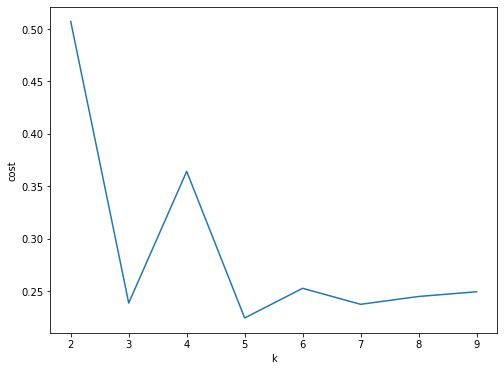

In [14]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')